<small><i>This notebook was put together by Morgan Fouesneau for MPIA's Advanced Python workshop</i></small>

### MPIA Foundational Workshops #6
# Advanced Python
## **Morgan Fouesneau & Iva Momcheva**
*Max-Planck Institute for Astronomy*
✉️ ds@mpia.de
(Nov 2022)

In [ ]:
%%file requirements.txt
numpy
matplotlib
numba 
astropy

In [ ]:
!pip install -q pip --upgrade
!pip install -q -r requirements.txt

In [1]:
# make sure pylab runs inline when using the notebook
%matplotlib inline
import numpy as np
import pylab as plt

light_minimal = {
    'font.family': 'serif',
    'font.size': 14,
    "axes.titlesize": "x-large",
    "axes.labelsize": "large",
    'axes.edgecolor': '#666666',
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": "8",
    "xtick.minor.size": "4",
    "ytick.major.size": "8",
    "ytick.minor.size": "4",
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'ytick.color': '#666666',
    'xtick.color': '#666666',
    'xtick.top': False,
    'ytick.right': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'image.aspect': 'auto'
}

plt.style.use(light_minimal)

# Code typing in Python

Python >= 3.5

## Python is a __dynamically typed__  language

- Variables have __implicit__ types
- types can change with a simple assignment

In [2]:
a = 5       # integer
a = "text"  # string

- Python >= 3.5 concept of [type annotations](https://docs.python.org/3/library/typing.html)
    - add hints about the expected type of a parameter

In [3]:
a: int = 5
b: str = "text"

## Typing Examples

In [4]:
def scale(scalar, vector):
    return [scalar * num for num in vector]

new_vector = scale(2.0, [1.0, -4.2, 5.4])

In [5]:
Vector = list[float]

def scale(scalar: float, vector: Vector) -> Vector:
    return [scalar * num for num in vector]

new_vector = scale(2.0, [1.0, -4.2, 5.4])

ℹ️ Note how readable the second version becomes.

## Function Annotations

- The following adds __annotations__ to your function

In [6]:
Vector = list[float]

def scale(scalar: float, vector: Vector) -> Vector:
    return [scalar * num for num in vector]

scale.__annotations__

{'scalar': float, 'vector': list[float], 'return': list[float]}

- One can use these to enforce variable types. (not the default)
* Documentation is not "redundant" (bad practice example)
    ```python
    def func(a: IpAddress, b: List[Users], c: str) -> float: ...
    ```

## Variable Annotations

In [7]:
a: int = 5
b: str = "text"
__annotations__

{'a': int, 'b': str}

- One can use these to enforce variable types. (not the default)

In [8]:
a = "text"               # what happens?
a: "dummy quantity" = 5  # Does it work? What could this mean?

⚠️ __not making a statically typed language out of Python__

### How to *manually* check types

```python
# pseudo code
func: Callable(args: Sequence[Any], kwargs: Dict[str, Any]) = ...
sig = inspect.signature(func: Callable)
for value, (name, pardef) in zip(args, sig.parameters.items()):
    try:
        valid = isinstance(value, pardef.annotation)
    except GenericAnnotationTypeError:  # e.g. List[...], Sequence[...]
        valid = isInstanceGenericType(value, pardef.annotation)  # complex function to write
    except NoAnnotationError:  # ⚠️   "NoAnnotationError" does not exists
        valid = True
    else:
        valid = False
    if not valid:
        raise RuntimeError(f"TypeCheck {name:s}: got {value} not of type {pardef.annotation}.")
result = func(*args, **kwargs)
if not isInstanceGenericType(result, sig.return_annotation):
    raise RuntimeError(f"TypeCheck returned value: got {value} not of type {sig.return_annotation}.")
```

In [9]:
from typing import Any, Sequence, Callable
from itertools import cycle
import inspect

Vector = list[float]

def scale(scalar: float, vector: Vector) -> Vector:
    return [scalar * num for num in vector]


def AssertInstanceGenericType(name: str, value: Any, annotation: type) -> None:
    if annotation == inspect._empty:  # empty annotation
        return
    try:
        if not isinstance(value, annotation):
            raise RuntimeError(f"TypeCheck {name:s}: got {value} not of type {annotation}.")
    except TypeError:  # e.g. List[...], Sequence[...]
        orig, what = annotation.__origin__, annotation.__args__
        if not isinstance(value, orig):
            raise RuntimeError(f"TypeCheck {name:s}: got {value} not of type {annotation}.")
        for e, (subval, subw) in enumerate(zip(value, cycle(what))):
            AssertInstanceGenericType(f"{name:s}[{e:d}]", subval, subw)

def isinstanceGenericType(name: str, value: Any, annotation: type, verbose: bool = True) -> bool:
    try:
        AssertInstanceGenericType(name, value, annotation)
        return True
    except RuntimeError as err:
        if verbose:
            print(err)
        return False

def assert_types(func: Callable,
                *args: Sequence[Any],
                **kwargs: dict[str, Any]) -> Any:

    sig = inspect.signature(func)
    for value, (name, pardef) in zip(args, sig.parameters.items()):
        AssertInstanceGenericType(name, value, pardef.annotation)

    result = func(*args, **kwargs)
    AssertInstanceGenericType("returned value", result, sig.return_annotation)
    return result

In [10]:
isinstanceGenericType('dummy', 2.0, int)

TypeCheck dummy: got 2.0 not of type <class 'int'>.


False

In [11]:
isinstanceGenericType('dummy', 2, int)

True

In [12]:
isinstanceGenericType('dummy', [2, 3.0], list[int])

TypeCheck dummy[1]: got 3.0 not of type <class 'int'>.


False

In [13]:
isinstanceGenericType('dummy', [2, 3.0], list[int | float])

TypeError: unsupported operand type(s) for |: 'type' and 'type'

In [14]:
assert_types(scale, 2.0, [1.0, -4.2, 5.4])

[2.0, -8.4, 10.8]

In [15]:
assert_types(scale, 2.0, [1.0, -4.2, 5])

RuntimeError: TypeCheck vector[2]: got 5 not of type <class 'float'>.

### How to *enforce* types ?

- manually: (⚠️ Not recommended)
    - Rapidly complex to check all types and subtypes.
    - Not optimized checks will lead to significant overhead.
- Maybe not worth apart from debugging phases.


### With CI/CD: Type check and find common bugs (:thumbsup:)

- [mypy](https://mypy.readthedocs.io/en/stable/) is a static analyzer, or a lint-like tool.
- others: [pyre](https://pyre-check.org/), [pytype](https://github.com/google/pytype),  [Enforce](https://github.com/RussBaz/enforce),[Pydantic](https://pypi.org/project/pytypes/)
- keep an eye on [Mypyc](https://github.com/mypyc/mypyc) not yet ready for general use, but it can compile some type annotated Python code to C extensions.

## Typing Pros & Cons...

- __Why?__ Increasing code
    - **quality** (for you to think about types)
    - **readability** (standard documentation; allowing automated checks)
    - improve IDEs and linters (as providing standard documentation)

- __cons__
    - rapidly cumbersome, not always with useful predictable types
    - no standard to enforce types.
    - introduce a slight penalty in startup time.
    - Loosing Python's flexibility

# Principles of OOP in Python

### Object Oriented Programming

## What is "object"?

<style>
div.fourcols {
  margin-top: 35px;
  column-count: 4;
}
div.fourcols p:first-child,
div.fourcols h1:first-child,
div.fourcols h2:first-child,
div.fourcols ul:first-child,
div.fourcols ul li:first-child,
div.fourcols ul li p:first-child {
  margin-top: 0 !important;
}
div.fourcols p.break {
  break-before: column;
  margin-top: 0;
}
</style>

<div class="fourcols" style="align-text: center;">

![h:200](https://thumbs.dreamstime.com/b/light-bulb-brain-idea-hand-drawn-white-background-eps-54141958.jpg)
A concept

<p class="break"></p>

![h:200](https://upload.wikimedia.org/wikipedia/commons/e/ec/Regular_triangle.svg)
an "object"
_aka triangle_

<p class="break"></p>

__attributes__ (properties)
- 3 edges
- edgecolor
- facecolor
...

<p class="break"></p>

__methods__ (functions)
- get_edges
- set_color
- move_to
...
</div>

$\displaystyle{\textrm{concept described by class Triangle} = \underbrace{\textrm{attributes + methods}}_{\textrm{encapsulation}}}$

## Important Vocabulary: _object_ vs. _class_

* a **class** is a definition, aka _blueprint_ or _template_ from which objects are created
* an **object** is an entity __instanciated__ from a class.
* example:

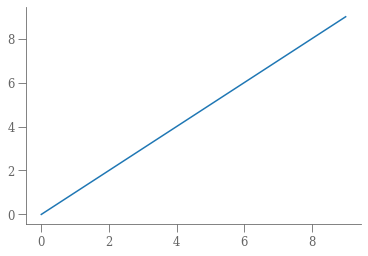

In [16]:
import pylab as plt
r = plt.plot(range(10))
r

`r` contains objects of class `Line2D` (or `matplotlib.lines.Line2D`)

## In python, *everything* is an object

* `s` is an object from class `str`

In [17]:
s = "some text"
s1 = s.strip()  # remove leading/trailing spaces
su = s1.upper() # make uppercase
print(su)

SOME TEXT


* __object\<dot\>method()__
* modules are objects too! (class module)
    ```python
    import numpy
    d = numpy.random.normal(0, 1, 100)
    ```
* as well as functions, code, even the running environment.

## OOP example with Matplotlib

[[<matplotlib.lines.Line2D at 0x11bb8fc70>],
 Text(0.5, 0, 'measured'),
 Text(0, 0.5, 'calculated'),
 Text(0.5, 1.0, 'Measured vs. Calculated'),
 None]

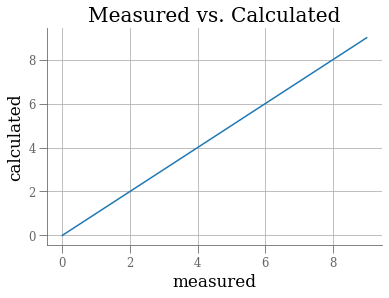

In [18]:
import pylab as plt
r = []
r.append( plt.plot(range(10)) )
r.append( plt.xlabel('measured') )
r.append( plt.ylabel('calculated') )
r.append( plt.title('Measured vs. Calculated') )
r.append( plt.grid(True) )
r

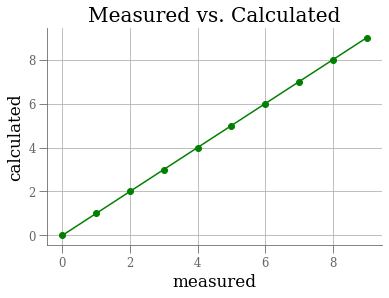

In [19]:
plt.plot(range(10))
plt.xlabel('measured')
plt.ylabel('calculated')
plt.title('Measured vs. Calculated')
plt.grid(True)
ax = plt.gca()       # gca == get current axis
line = ax.lines[0]
line.set_marker('o')
plt.setp(line, color='g');   # set properties

#### Objects allows to make nice figures with ease

but

### What about science?

## How do we define our own classes / objects?

## Let's make a class "Vector"

__Class Vector__:
- __attrs__:
    x, y, z
- __Methods__:
    addition, scalar product, projection

In [20]:
class Vector(object):
    def __init__(self):
        pass

When a class defines an `__init__()` method, class instantiation automatically invokes `__init__()` for the newly-created class instance. So in this example, a new, initialized instance can be obtained by:

**Note**: Often, the first argument of a method is called `self`. 
This is nothing more than a convention: the name self has absolutely no special meaning to Python. 
    
Note, however, that by not following the convention your code may be less readable to other Python programmers, and it is also conceivable that a class browser program might be written that relies upon such a convention.

In [21]:
class Vector:
    def __init__(self, x, y, z):
        """ Constructor """
        self.x, self.y, self.z = x, y, z
    def sum(self, other):
        """ add 2 vectors """
        return Vector(self.x + other.x,
                      self.y + other.y,
                      self.z + other.z)
    def scalar_prod(self, other):
        """ product of 2 vectors """
        return (self.x * other.x +
                self.y * other.y +
                self.z * other.z)

In [22]:
a = Vector(1,0,0)
b = Vector(0,1,0)
print("a . b = ", a.scalar_prod(b))
print(a.sum(b)) #???

a . b =  0


__What's wrong with `print`?__

* Print is equivalent to
    `str(a)` or `a.__str__()`
* we need to define `__str__()`

In [25]:
class Vector:
    def __init__(self, x, y, z):
        """ Constructor """
        self.x, self.y, self.z = x, y, z
    def sum(self, other):
        """ add 2 vectors """
        return Vector(self.x + other.x,
                      self.y + other.y,
                      self.z + other.z)
    def scalar_prod(self, other):
        """ product of 2 vectors """
        return (self.x * other.x +
                self.y * other.y +
                self.z * other.z)
    def __str__(self):
        """ str representation """
        return "Vector({s.x},{s.y},{s.z})".format(s=self)

In [26]:
a = Vector(1,0,0)
b = Vector(0,1,0)
print("a . b = ", a.scalar_prod(b))
print(a.sum(b)) #???

a . b =  0
Vector(1,1,0)


`object.__repr__(self)`

Called by the `repr()` built-in function and by string conversions (reverse quotes) to compute the "official" string representation of an object. 

`object.__str__(self)`

Called by the `str()` built-in function and by the print statement to compute the "informal" string representation of an object. 


http://docs.python.org/2/reference/datamodel.html

What about checking that $x^2 + y^2 + 2\cdot x \cdot y = (x + y) ^ 2$

In [27]:
x = Vector(1, 0, 0)
y = Vector(0, 1, 0)
z = Vector(0, 0, 1)

# x.scalar_prod(x).sum(y.scalar_prod(y))
x.scalar_prod(x) + y.scalar_prod(y) + 2 * x.scalar_prod(y) == x.sum(y).scalar_prod(x.sum(y))

True

## Overloading operators

- How would you implement $a^2 + b^2$?
    - ```python
        a.scalar_prod(a).sum(b.scalar_prod(b))
        ```
    - wouldn't be better to use `+` and `*` operators  ??

* Special methods such as `__str__`
    `__add__`, `__sub__`, `__mul__`, `__matmul__`, `__div__`,  `__pow__`, ... __and many others__
    see [python datamodel](http://docs.python.org/reference/datamodel.html)

## Exercise: Complete the `Vector` class

- manage a string representation
- handle common operators `+`, `–`
- Implement a scalar product solution based on `*`
- Implement vector product based on `@`

In [ ]:
# x ** 2 + y ** 2 + 2 * x * y == (x + y) ** 2

In [41]:
class Vector(object):
    def __init__(self, x, y, z):
        self.x, self.y, self.z = x, y, z
    def __repr__(self):
        # String repr, called when >>> Vector([1,2,3]) <CR>
        return self.__str__() + ", " + object.__repr__(self)
    def __str__(self):
        """ str representation """
        return "Vector({s.x},{s.y},{s.z})".format(s=self)
    def __add__(self, p):
        if isinstance(p, Vector):	# if p Vector, sum of p1*p2
            return Vector(self.x + p.x, self.y + p.y, self.z + p.z)
        return Vector(self.x + p, self.y + p, self.z + p)
    def __mul__(self, p):
        if isinstance(p, Vector):	# scalar product p1*p2
            return self.x * p.x + self.y * p.y + self.z * p.z
        return Vector(self.x * p, self.y * p, self.z * p)
    def __matmul__(self, p):
        """ self @ p as vector product """
        if not isinstance(p, Vector):
            raise RuntimeError("second argument is not a Vector")
        x = self.y * p.z - self.z * p.y
        y = self.z * p.x - self.x * p.z
        z = self.x * p.y - self.y * p.x
        return Vector(x, y, z)
    def __pow__(self, p):
        return sum([self.x ** p, self.y ** p, self.z ** p])

In [42]:
x = Vector(1, 0, 0)
y = Vector(0, 1, 0)
z = Vector(0, 0, 1)

xy = x * y
print("x.y = ", xy)
print(x)
x * x + y * y + x * y * 2 == (x + y) ** 2

x.y =  0
Vector(1,0,0)


True

### Bonus exercise

Generalize the class vector and all operations to N-dimensions
(tip: you can use numpy arrays)


In [43]:
import numpy as np

class Vector(object):
    def __init__(self, x):
        self.x = np.atleast_1d(x)
    def __repr__(self):
        # String repr, called when >>> Vector([1,2,3]) <CR>
        return self.__str__() + ", " + object.__repr__(self)
    def __str__(self):
        """ str representation """
        return "Vector({s.x})".format(s=self)
    def __add__(self, p):
        if isinstance(p, Vector):	# if p Vector, sum of p1*p2
            return Vector(self.x + p.x)
        return Vector(self.x + p)
    def __mul__(self, p):
        if isinstance(p, Vector):	# scalar product p1*p2
            return np.sum(self.x * p.x)
        return Vector(self.x * p)
    def __matmul__(self, p):
        """ self @ p as vector product """
        if not isinstance(p, Vector):
            raise RuntimeError("second argument is not a Vector")
        return Vector(x @ p.x)
    def __pow__(self, p):
        return sum(self.x ** p)

In [45]:
x = Vector([1, 0, 0])
y = Vector([0, 1, 0])
z = Vector([0, 0, 1])

xy = x * y
print("x.y = ", xy)
print(x)
x * x + y * y + x * y * 2 == (x + y) ** 2

x.y =  0
Vector([1 0 0])


True

## Functions are objects too! they implement `__call__`

- __exercise__: Create a "function" `interp` of two sequences `x`, `y` that
    - keep _in mind_ the input data
    - and when called with a sequence `xn`, interpolates the data `yn = y(xn)`

ℹ️ There are two approaches possible (using a class or only functions)
💡 Don't code the interpolation, use `np.interp` instead.

In [47]:
import numpy as np
import pylab as plt

class Interp:
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __call__(self, xn):
        return np.interp(xn, self.x, self.y)

def interpfn(x, y):
    def f(xn):
        return np.interp(xn, x, y)
    return f

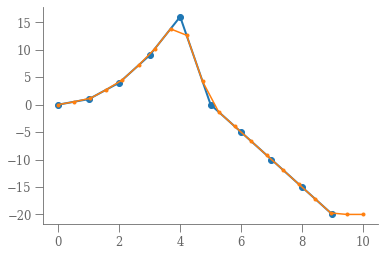

In [48]:
import numpy as np
import pylab as plt
x = np.arange(10)
y = np.hstack([x[: 5] ** 2, 25 - 5 * x[5:]])
interp = Interp(x, y)
xn = np.linspace(0, 10, 20)
plt.plot(x, y, 'o-', lw=2)
plt.plot(xn, interp(xn), '.-')

## When to use classes or not?

[Zen of python](https://peps.python.org/pep-0020/)

1. Classes are useful tools.
2. Simple > complex > complicated.
3. Practicality beats purity.
4. Do not reinvent the wheel every time.
   When tools you already work: use & adapt them.
5. Readability counts!

[Stop writing classes](https://www.youtube.com/watch?v=o9pEzgHorH0) by Jack Diederich (30 min video)

![bg right:30% fit](https://franzcalvo.files.wordpress.com/2016/01/001f9-zen.png?w=439&zoom=2)

## Exercise: Coding the an IMF "package"

All mass functions share __common__ properties
- $dN/dM$,
how mass is frequently formed?
    - Probability distribution function
    - usually defined as broken power-laws

ℹ️ Some tips to come in the next slides

## Class Inheritance: Establish relationships between objects.
Of course, a language feature would not be worthy of the name “class” without supporting inheritance. The syntax for a derived class definition looks like this:

In [49]:
class IMF(object):
    mass = [0.1, 120.]

    
class Salpeter(IMF):
    pass

In [51]:
f = Salpeter()
print(f.mass)

[0.1, 120.0]


Execution of a derived class definition proceeds the same as for a base class. When the class object is constructed, the base class is remembered. This is used for resolving attribute references: if a requested attribute is not found in the class, the search proceeds to look in the base class. This rule is applied recursively if the base class itself is derived from some other class.

There’s nothing special about instantiation of derived classes: `Salpeter()` creates a new instance of the class. Method references are resolved as follows: the corresponding class attribute is searched, ascending up the chain of parent classes if necessary, and the method reference is valid if this yields a function object.

Derived classes may override methods of their base classes.

An overriding method in a derived class may in fact want to extend rather than simply replace the base class method of the same name. There is a simple way to call the base class method directly: just call `IMF.methodname(self, *args, **kwargs)`. It is common to call the parent constructor in the derived class constructor:

```python
def Salpeter(IMF):
    def __init__(self, *args, **kwargs):
        IMF.__init__(self, *args, **kwargs)
```
or 
```python
def Salpeter(IMF):
    def __init__(self, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
```

Note that the above example is equivalent to doing nothing special and thus can be omitted (it is the implicit definition from inheritance)

**The requirements are:**

* Computing the expected number of stars per mass bin
* Computing the mass enclosed in a given mass range
* Being able to draw random masses from an IMF
* What is the average mass predicted by an IMF?

Below is a template of IMF class. **Feel free to adapt.**

In [52]:
class IMF(object):
    """
    IMF object class
    let you define an IMF as multiple power-laws.

    attributes:
        norm:    norm of the function
    """

    def __init__(self, *args, **kwargs):
        """
        """
        pass

    def get_enclosed_mass(self, Mmin, Mmax):
        """Get the enclosed mass over a given mass range.
        """
        pass

    def get_enclosed_Nstar(self, Mmin, Mmax):
        """Get the enclosed dN over a given mass range
        """
        pass

    def get_avg_mass(self, Mmin, Mmax):
        """ get the avg mass over a given range """
        pass

    def getValue(self, m):
        """ returns the value of the normalized IMF at a given mass m:
            note: m can be an iterable
        """
        pass

    def random(self, N, massMin=None, massMax=None):
        """ Draw samples from this distribution
        Samples are distributed over the interval [massMin, massMax]
        Interval is truncated to the IMF range definition if it extents beyond it. 
        (taken as is otherwise)
        """
        pass
    
    def __call__(self, m=None):
        return self.getValue(m)

### Some common IMF

Below some definitions in terms of `x` the mass interval edges and `a` the power-law indices on each interval.

* Kroupa2001
    ```python
    x = [0.01, 0.08, 0.5, 1., 150.]
    a = [0.7, -0.3, -1.3, -1.3]
    ```
* Kennicut
    ```python
    x = [0.1, 1., 120.]
    a = [-0.4, -1.5]
    ```
* Salpeter
    ```
    x = [0.1, 120.]
    a = [-1.35]
    ```

### Mathematical Background

An IMF is a probability density distribution function: 
$\displaystyle{p(m | IMF) = \frac{1}{Z} \frac{dN}{dm}},$
where its integral is unity (by definition) gives use
$\displaystyle{Z = \int_{m_{min}}^{m_{max}} \frac{dN}{dm} dm}.$
The function is continuous.

💡 _The first task of the contructor will be to create a continous function from the broken power-law definition and to normalize it properly._

⚠️ when indexes of the different power-laws are in units of $dN/dM$, $-2.35$ corresponds to a Salpeter IMF. But, sometimes you could find $-1.35$, which corresponds to an index defined in terms of $dN/dlog(M)$.

From this, the fractional number of stars within an interval $[m_1, m_2]$ is the integral:
$\displaystyle{n_\star = \frac{1}{Z} \int_{m_{1}}^{m_{2}} \frac{dN}{dm} dm},$
and the mass is expectation of the distribution, 
$\displaystyle{m_\star = \frac{1}{Z} \int_{m_{1}}^{m_{2}} m \frac{dN}{dm} dm}.$
The average mass over this interval is then $\displaystyle{\overline{m}_\star = \frac{m_\star}{n_\star}}$

**Drawing random samples**

drawing random numbers from a given distribution can be done using multiple methods. When you can compute or accurately estimate the integral of your function, the optimal way is to use it, aka "_Inverse transform sampling_". Briefly:

let's call $F(x) = \int_{m_{min}}^{x} p(m) dm$

Since we use power laws, the intregral is trivial. if $x$ such as $M[i] \leq x < M[i+1]$, with $M$ the masses used to define the IMF:

$F(x) = F(M[i]) + \frac{1}{Z} \frac{1}{a[i] + 1} \left( x ^{a[i] + 1} - M[i] ^ {a[i] + 1}\right)$

The trick is to observe that $F(x)$ varies between $0$ and $1$, and that there is a unique mapping between $F(x)$ and $x$ ($F$ is a bijective function). I spare the proof but we can demonstrate that drawing uniform $F(x)$ numbers between 0 and 1 will then give us $x$ values that exactly follow the IMF.

In our case, the previous equation is inversible, and once you extract $x$ as a function of $F(x)$ you're done.


### Your solution

In [62]:
import numpy as np


class IMF(object):
    """
    Here is one possible implementation, which
    let you define an IMF as multiple power-laws
    """
    def __init__(self, nI, x, a, massMin=0.1, massMax=120., name=None):
        """__init__ - constructor of the class

        Parameters
        ----------
        nI: int
            number of definition intervals

        x:  iterable
            interval edges (of len nI + 1)

        a:  iterable
            power-law indexes (of len nI) in units of dN/dM (Salpeter corresponds to -2.35)

        massMin: float
            minimal mass

        massMax:
            maximal mass

        name: string
            optional name

        notes
        -----
        1 - the mass range can be restricted by massMin, massMax while keeping
            the official definition.
        2 - indexes of the different power-laws are assumed to be in units of
            dN/dM, ie, -2.35 corresponds to a Salpeter IMF. However, sometimes
            you could find -1.35, which corresponds to an index defined in
            terms of dN/dlog(M).
        """
        # Store relevant information
        # ==========================
        self.nIMFbins  = nI
        self.massinf   = np.asarray(x)
        self.slope     = np.asarray(a)
        self.name      = name
        self.coeffcont = np.zeros(np.size(a))
        self.massMin   = massMin
        self.massMax   = massMax

        # Make functional form
        # ====================
        # the first step is to build the functional form of the IMF:
        # i.e., make a continuous function and compute the normalization

        # continuity
        # ----------
        # given by:  c[i-1] * x[i] ^ a[i-1] = c[i] * x[i] ^ a[i]
        # arbitrary choice for the first point, which will be corrected by the
        # normalization step.
        self.coeffcont[0] = 1.
        for i in range(1, nI):
            self.coeffcont[i]  = (self.coeffcont[i - 1])
            self.coeffcont[i] *= (x[i] ** (a[i - 1] - a[i]))

        # normalize
        # ---------
        # depends on the adpoted definition of the IMF indexes:
        # either dN/dM or dN/dlog(M). In this example we consider that indexes
        # are given in units of dN/dM.
        # get the norm : integral(imf(M) dM) = 1 seen as a prob dist. funct."""
        self.norm = 1.  # will be updated at the next line
        self.norm = self.get_enclosed_Nstar(self.massMin, self.massMax)

        # Compute the average mass
        self.avg = self.get_avg_mass(self.massMin, self.massMax)

    def get_enclosed_Nstar(self, Mmin, Mmax):
        """get_enclosed_Nstar - Get the enclosed dN over a given mass range.
        Analytic integration, Sum(imf(m) dm)
        Note: no extrapolation outside the original mass range definition of the IMF.

        keywords
        --------
        Mmin, Mmax: float, float
            lower and upper masses

        returns
        -------
        r: float
            enclosed dN within [Mmin, Mmax]
        """
        x = self.massinf
        a = self.slope
        c = self.coeffcont

        # will be useful in the integration
        b = a + 1.

        val = 0.
        # analytical integration of a power law
        for i in range(0, self.nIMFbins):
            if (Mmin < x[i + 1]) & (Mmax > x[i]):
                if x[i] <= Mmin:
                    x0 = Mmin
                else:
                    x0 = x[i]
                if x[i + 1] <= Mmax:
                    x1 = x[i + 1]
                else:
                    x1 = Mmax
                # careful if the index is 1
                if a[i] == 1:
                    S = c[i] * (np.log(x1) - np.log(x0))
                else:
                    S = c[i] / b[i] * ( (x1) ** (b[i]) - (x0) ** (b[i]) )
                val += S

        return val * self.norm

    def get_enclosed_mass(self, Mmin, Mmax):
        """get_enclosed_mass - Get the enclosed mass over a given mass range.
        Analytic integration, integral(m * imf(m) dm)

        Note: no extrapolation outside the original mass range definition of the IMF.

        Parameters
        ----------
        Mmin, Mmax: float, float
            lower and upper masses

        returns
        -------
        r: float
            enclosed mass within [Mmin, Mmax]
        """
        x = self.massinf
        a = self.slope
        c = self.coeffcont

        # will be useful in the integration
        b = a + 2.

        val = 0.
        # analytical integration of a power law
        for i in range(0, self.nIMFbins):
            if (Mmin < x[i + 1]) & (Mmax > x[i]):
                if x[i] <= Mmin:
                    x0 = Mmin
                else:
                    x0 = x[i]
                if x[i + 1] <= Mmax:
                    x1 = x[i + 1]
                else:
                    x1 = Mmax

                # careful if the index is 1
                if a[i] == 2:
                    S = c[i] * (np.log(x1) - np.log(x0))
                else:
                    S = c[i] / b[i] * ( (x1) ** (b[i]) - (x0) ** (b[i]) )
                val += S

        return val * self.norm

    def getValue(self, m):
        """getValue - returns the value of the normalized IMF at a given mass m
            IMF(m) = 1 / norm * c * m ** a
            and integral( IMF(m) dm ) = 1

        Parameters
        ----------
        m: float or iterable of floats
            masses at which evaluate the function

        returns
        -------
        r: float or ndarray(dtype=float)
            evaluation of the function (normalized imf)
        """
        # if m is iterable
        if getattr(m, '__iter__', False):
            return np.asarray([ self.getValue(mk) for mk in m])
        else:
            # extrapolation
            if (m > self.massMax) or (m < self.massMin):
                return 0.
            # exact value exists
            elif m in self.massinf[:-1]:
                ind = np.where(m == self.massinf)
                return float(float(self.coeffcont[ind]) / self.norm * m ** self.slope[ind])
            # otherwise do the evaluation with the correct interval
            else:
                i = 0
                if self.nIMFbins > 1:
                    while m > self.massinf[i]:
                        i += 1
                    i -= 1
                if self.massinf[i] > self.massMax:
                    return 0.
                else:
                    return float(float(self.coeffcont[i]) / self.norm * m ** self.slope[i])

    def get_avg_mass(self, Mmin, Mmax):
        """ get the avg mass over a given range
              < M > = integral(M * imf * dM) / integral(imf * dM)

        :param Mmin: float, lower mass
        :param Mmax: float, upper mass
        """
        return self.get_enclosed_mass(Mmin, Mmax) / self.get_enclosed_Nstar(Mmin, Mmax)

    def random(self, N, massMin=None, massMax=None):
        """random - Draw mass samples from this distribution
        Samples are distributed over the interval [massMin, massMax]
        Interval is truncated to the IMF range definition if it extents beyond it. (taken as is otherwise)

        Parameters
        ----------

        N: int
            size of the sample

        massMin: float
            lower mass (default self.massMin)

        massMax: float
            upper mass (default self.massMax)

        returns
        -------

        r: ndarray(dtype=float)
            returns an array of random masses

        method
        ------

        drawing random numbers from a given distribution can be done using
        multiple methods. When you can compute or accurately estimate the
        integral of your function, the optimal way is to use it, aka "Inverse
        transform sampling". Briefly:

        let's call F(x) = integral( imf(m) dm, m=massMin..x)

        Since we use power laws, the intregral is trivial. if x such as
        M[i] <= x < M[i+1], with M the masses used to define the IMF:

        F(x) = F(M[i]) + 1 / norm * 1 / (a[i] + 1) ( x ** (a[i] + 1) - M[i] ** (a[i] + 1) )

        The trick is to observe that F(x) varies between 0 and 1, and that
        there is a unique mapping between F(x) and x (F is a bijective
        function).
        I spare the proof but we can demonstrate that drawing uniform F(x)
        numbers between 0 and 1 will then give us x values that exactly follow
        the imf.

        In our case, the previous equation is inversible, and once you extract
        x as a function of F(x) you're done.
        """

        # check keyword values, default is the IMF definition
        massMin = massMin or self.massMin
        massMax = massMax or self.massMax

        beta = self.slope + 1.

        # compute the cumulative distribution values at each mass interval edge
        F = np.zeros(self.nIMFbins + 1)
        F[-1] = 1.0
        for i in range(1, self.nIMFbins):
            F[i] = F[i - 1] + 1. / self.norm * (self.coeffcont[i - 1] / (beta[i - 1])) * ( self.massinf[i] ** (beta[i - 1]) - self.massinf[i - 1] ** (beta[i - 1]) )

        #find intervals of massMin and massMax
        for k in range(self.nIMFbins):
            if massMin >= self.massinf[k]:
                mink = k
            if massMax >= self.massinf[k]:
                maxk = k
        if massMin < self.massMin:
            Fmin = 0.
        elif massMin >= self.massMax:
            return
        else:
            i = mink
            Fmin = F[i] + 1. / self.norm * ( self.coeffcont[i] / (beta[i]) ) * ( massMin ** (beta[i]) - self.massinf[i] ** (beta[i]) )

        if massMax >= self.massMax:
            Fmax = 1.0
        elif massMax < self.massMin:
            return
        else:
            i = maxk
            Fmax = F[i] + 1. / self.norm * ( self.coeffcont[i] / (beta[i]) ) * ( massMax ** (beta[i]) - self.massinf[i] ** (beta[i]) )

        x = np.random.uniform(Fmin, Fmax, N)
        y = np.zeros(N)
        for k in range(self.nIMFbins):
            ind = np.where((x >= F[k]) & (x < F[k + 1]))
            if len((ind)[0]) > 0:
                y[ind] = self.massinf[k] * ( 1. + (x[ind] - F[k]) / (self.massinf[k] ** (beta[k])) * ( beta[k] ) * self.norm / self.coeffcont[k]) ** (1. / (beta[k]))
        return y

    def __call__(self, m=None):
        """__call__ - make a callable object (function like)

        Parameters
        ----------

        m: float or iterable or None
            if None calls self.info()
            else calls self.getValue(m)
        """
        if m is None:
            return self.info()
        return self.getValue(m)

    def info(self):
        """ prints a quick summary of the functional object """
        txt = """IMF: {s.name}, IMF(m) = 1./norm * c * m ** a
        nI = {s.nIMFbins},
        norm = {s.norm}, 1/norm = {invnorm},
        Average mass = {s.avg},
        m[] = {s.massinf},
        a[] = {s.slope},
        c[] = {s.coeffcont}"""
        print(txt.format(s=self, invnorm=1. / self.norm))


# Deriving common IMF from the literature
#=========================================

# in the definitions below, power-law indexes are given for the dN/dlog(M)
# definition and accordingly converted before usage

class Kennicutt(IMF):
    def __init__(self):
        nI = 2
        x = [0.1, 1., 120.]
        a = [-0.4, -1.5]
        a = np.asarray(a) - 1
        massMin = 0.1
        massMax = 120.
        IMF.__init__(self, nI, x, a, massMin, massMax, name='Kennicutt')


class Kroupa2001(IMF):
    def __init__(self):
        nI = 4
        x = [0.01, 0.08, 0.5, 1., 150.]
        a = [0.7, -0.3, -1.3, -1.3]
        a = np.asarray(a) - 1
        massMin = 0.01
        massMax = 120.
        IMF.__init__(self, nI, x, a, massMin, massMax, name='Kroupa 2001')


class Kroupa93(IMF):
    def __init__(self):
        nI = 3
        x = [0.1, 0.5, 1., 120.]
        a = [-0.3, -1.2, -1.7]
        a = np.asarray(a) - 1
        massMin = 0.1
        massMax = 120.
        IMF.__init__(self, nI, x, a, massMin, massMax, name='Kroupa 1993')


class Salpeter(IMF):
    def __init__(self):
        nI = 1
        x = [0.1, 120.]
        a = [-1.35]
        a = np.asarray(a) - 1
        massMin = 0.1
        massMax = 120.
        IMF.__init__(self, nI, x, a, massMin, massMax, name='Salpeter')


class MillerScalo(IMF):
    def __init__(self):
        nI = 3
        x = [0.1, 1., 10., 120.]
        a = [-0.4, -1.5, -2.3]
        a = np.asarray(a) - 1
        massMin = 0.1
        massMax = 120.
        IMF.__init__(self, nI, x, a, massMin, massMax, name='Miller & Scalo')


class Scalo98(IMF):
    def __init__(self):
        nI = 3
        x = [0.1, 1., 10., 120.]
        a = [-0.2, -1.7, -1.3]
        a = np.asarray(a) - 1
        massMin = 0.1
        massMax = 120.
        IMF.__init__(self, nI, x, a, massMin, massMax, name='Scalo 1998')


class Scalo86(IMF):
    def __init__(self):
        nI = 24
        x = [    1.00000000e-01,   1.10000000e-01,   1.40000000e-01,
                 1.80000000e-01,   2.20000000e-01,   2.90000000e-01,
                 3.60000000e-01,   4.50000000e-01,   5.40000000e-01,
                 6.20000000e-01,   7.20000000e-01,   8.30000000e-01,
                 9.80000000e-01,   1.17000000e+00,   1.45000000e+00,
                 1.86000000e+00,   2.51000000e+00,   3.47000000e+00,
                 5.25000000e+00,   7.94000000e+00,   1.20200000e+01,
                 1.82000000e+01,   2.69200000e+01,   4.16900000e+01,
                 1.20000000e+02     ]
        a = [  3.2   ,  2.455,  2.   ,  0.3  ,  0.   ,  0.   , -0.556, -1.625,
               -1.833, -1.286,  1.5  , -1.857,  0.   , -2.333, -3.455, -1.692,
               -2.571, -1.722, -1.611, -1.667, -2.333, -1.353, -0.947, -1.778]
        a = np.asarray(a) - 1
        massMin = 0.1
        massMax = 120.
        IMF.__init__(self, nI, x, a, massMin, massMax, name='Scalo 1986')

Plot at least a couple of mass functions on the same figure

In [63]:
imf = Salpeter()
imf.info()

IMF: Salpeter, IMF(m) = 1./norm * c * m ** a
        nI = 1,
        norm = 16.5819640406949, 1/norm = 0.060306487069072975,
        Average mass = 0.3534872405601367,
        m[] = [1.0e-01 1.2e+02],
        a[] = [-2.35],
        c[] = [1.]


In [105]:
imf = Kroupa2001()
imf.info()

IMF: Kroupa 2001, IMF(m) = 1./norm * c * m ** a
        nI = 4,
        norm = 0.503249268284521, 1/norm = 1.9870868434817714,
        Average mass = 0.37970570399992787,
        m[] = [1.0e-02 8.0e-02 5.0e-01 1.0e+00 1.5e+02],
        a[] = [-0.3 -1.3 -2.3 -2.3],
        c[] = [1.   0.08 0.04 0.04]


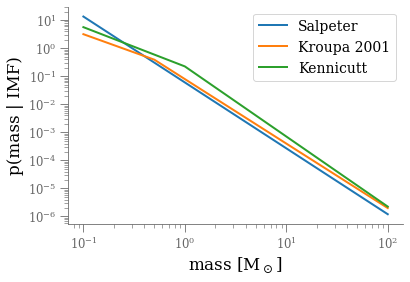

In [64]:
logm = np.arange(np.log10(0.1), np.log10(120), 0.1)
m = 10 ** logm
for imf_cls in (Salpeter, Kroupa2001, Kennicutt):
    imf = imf_cls()
    plt.plot(m, imf(m), label=imf.name, lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'mass [M$_\odot$]')
plt.ylabel(r'p(mass | IMF)')
plt.legend()
    

Draw a random sample of N masses from one mass function and show that the sample follows the desired distribution

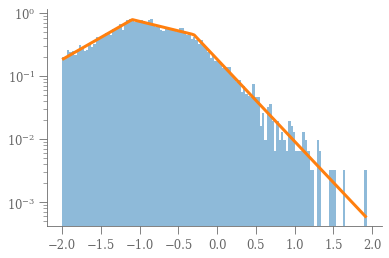

In [104]:
imf = Kroupa2001()
rvs = imf.random(10_000)  #10000 10_000
_, b, _ = plt.hist(np.log10(rvs), log=True, 
                   bins=128, density=True, alpha=0.5)
c = 0.5 * (b[1:] + b[:-1])
dm = np.diff(10 ** b)
plt.plot(c, imf(10 ** c) * dm / (b[1] - b[0]), lw=3)

# Decorators

A simple syntax for calling "higher-order functions".

In [72]:
def say_hello(name: str) -> str:
    return f"Hello {name:s}"

def be_awesome(name: str) -> str:
    return f"Yo {name:s}, together we are the awesomest!"

def greet_bob(greeter_func: Callable) -> str:
    return greeter_func("Bob")

In [73]:
greet_bob(say_hello)

'Hello Bob'

In [74]:
greet_bob(be_awesome)

'Yo Bob, together we are the awesomest!'

ℹ️ `greet_bob` takes a function as argument. In Python, functions can be passed around and used as arguments

## Inner Functions

In [75]:
def parent() -> None:
    print("Printing from the parent() function")

    def first_child() -> None:
        print("Printing from the first_child() function")

    def second_child() -> None:
        print("Printing from the second_child() function")

    second_child()
    first_child()

In [76]:
parent()

Printing from the parent() function
Printing from the second_child() function
Printing from the first_child() function


ℹ️ _inner functions_ are local variables (scope dependent).

## Returning functions from functions

As any other variable, Python allows you to use functions as return values.

In [77]:
def parent() -> Callable:
    def inner() -> str:
        return "Hi, I am the inner function"
    return inner

In [78]:
parent()

<function __main__.parent.<locals>.inner() -> str>

In [79]:
parent()()

'Hi, I am the inner function'

## A first _useless_ decorator

a decorator __wraps a function into a function__

In [80]:
def deco(func: Callable) -> Callable:
    def wrapper(*args, **kwargs):
        print(f"Something before calling the function.")
        result = func(*args, **kwargs)
        print("Something after calling the function.")
        return result
    return wrapper

def say_whee():
    print("Whee!")

say_whee = deco(say_whee)

Can you guess what happens when you call `say_whee()`?

In [81]:
say_whee()

Something before calling the function.
Whee!
Something after calling the function.


What happened?
``` python
>>> say_whee = deco(say_whee)   # decoration of `say_whee`
>>> say_whee
<function deco.<locals>.wrapper at 0x7f3c5dfd42f0>
```

* Syntactic Sugar!

In [82]:
@deco
def say_whee():
    print("Whee!")

In [83]:
say_whee()

Something before calling the function.
Whee!
Something after calling the function.


## What's decorated?


In [84]:
help(say_whee)

Help on function wrapper in module __main__:

wrapper(*args, **kwargs)



How do we fix this? e.g., propagating documentation -->  `@functools.wraps`

In [85]:
from functools import wraps

def deco(func: Callable) -> Callable:
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Something before
        result = func(*args, **kwargs)
        # Something after
        return result
    return wrapper

## Some useful examples of decorators

- `timeit` - gives runtime of a function
- `memoize` - A quick caching
- `functools.lru_cache` - a LRU caching mechanism (built-in)
- `astropy.units.quantity_input` to validate the units of arguments/outputs

### a simple `timeit`

In [86]:
from functools import wraps
import time

def timeit(func):
    """Prints the runtime of decorated functions"""
    @wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer

@timeit
def waste_some_time(num_times):
    for _ in range(num_times):
        sum([i**2 for i in range(10000)])

waste_some_time(999)

Finished 'waste_some_time' in 3.3324 secs


## A quick caching `memoize`


In [87]:
import functools 


class memoize(dict):
    '''Caches a function's return value each time it is called
    and returns the cached value when called later with the same arguments. (not reevaluated).
    '''
    def __init__(self, func):
        self.func = func
        functools.update_wrapper(self, func)

    def __getitem__(self, *key):
        return dict.__getitem__(self, key)

    def __missing__(self, key):
        ret = self[key] = self.func(*key)
        return ret

    __call__ = __getitem__


@memoize
def fibonacci(n):
    "Return the nth fibonacci number."
    if n in (0, 1):
        return n
    return fibonacci(n-1) + fibonacci(n-2)

In [90]:
%timeit fibonacci(30)

169 ns ± 0.754 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


## built-in LRU cache decorator

- speed up consecutive runs of functions and operations using cache

In [91]:
from functools import lru_cache

@lru_cache
def factorial(n):
    return n * factorial(n-1) if n else 1

In [92]:
%timeit factorial(20)

48.8 ns ± 0.661 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


## Numba Jit

- The Numba package provides the jit decorator, which makes running more intensive software a lot easier without having to drop into C.

In [93]:
from numba import jit
import random

@jit(nopython=True)
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [97]:
monte_carlo_pi(100_000)

3.14064

## Validating Astropy.units `quantity_input`

- for validating the units of arguments to functions. ([doc](https://docs.astropy.org/en/stable/api/astropy.units.quantity_input.html))

In [98]:
import astropy.units as u

@u.quantity_input(myangle=u.arcsec)
def myfunction(myangle):
    return myangle ** 2

@u.quantity_input
def myfunction(myangle: u.arcsec):
    return myangle ** 2

@u.quantity_input
def myfunction(myangle: u.arcsec) -> u.deg ** 2:
    return myangle ** 2

In [ ]:
# Test here

## Stacking decorators

In [ ]:
@timeit
@lru_cache
def fibonacci(n):
    "Return the nth fibonacci number."
    if n in (0, 1):
        return n
    return fibonacci(n-1) + fibonacci(n-2)

In [ ]:
#Test here

In [ ]:
@lru_cache
@timeit
def fibonacci(n):
    "Return the nth fibonacci number."
    if n in (0, 1):
        return n
    return fibonacci(n-1) + fibonacci(n-2)

In [ ]:
#test here

⚠️ Ordering matters!

# Context managers

objects that defines the runtime context

## An example: open, process, and close a file/buffer

In [ ]:
%%file foo.txt
Lorem ipsum dolor sit amet, ea feugiat maiorum evertitur his. Rebum molestie scriptorem ad eam, duo posse nostro scaevola te. Vix dolorum iudicabit ad. Verear utamur vulputate eum id, ius ad ocurreret euripidis, eu qui dicant tritani fierent. Eam in latine voluptaria, erant audiam tacimates ea nec, iisque eripuit vim at.

An pri illum prodesset, sit no vocent imperdiet conclusionemque. Et has erat mediocritatem conclusionemque. Vel sint ferri sapientem ne. Quaeque scriptorem ius in, soleat adipiscing intellegam in duo, pro inani doctus facilis cu.

Pri ut mentitum necessitatibus, nulla labores perfecto sea te. At atqui aliquam his, est te meis percipit adipisci, atqui ocurreret ut pro. Ei pri vero explicari dissentias, vitae epicurei quaerendum nam ad, ut nam autem tation patrioque. Nibh eligendi maluisset eos ut, usu et utinam vidisse percipitur.

At wisi probo vel, et nostrum epicurei definiebas pri, an homero neglegentur reprehendunt has. Eu saepe oblique his, et vidisse detraxit mei. Unum vituperata duo ei, rebum deseruisse dissentiunt eum ne. Mel cu vitae salutatus tincidunt. Dictas utamur quo in, ei has percipit consequat.

Eu populo mentitum vis, esse alienum offendit ex nam, sea an ullum quando moderatius. Vis suscipit pertinacia te, ea ius nominavi iudicabit, cu congue veniam pri. Sea quot prompta reformidans at, dicat tractatos pri ne. Sed modo audire ne, dolor prompta eum cu. An duo etiam elaboraret interesset, te mea zril recteque. Equidem maiorum elaboraret id vis.

In [ ]:
fp = open("foo.txt", 'r')
for line in fp:
    # do something
    print(line[:10], '...')
fp.close()      

After many lines, I commonly forget to clean up and close the file. __But__ with a __context manager__, I can __automatically close the file__

In [ ]:
with open('foo.txt', 'r') as fp:
    for line in fp:
        # do something
        print(line[:10], '...')

fp.seek(0)

## What are context managers?

Context managers are normally invoked using the [with](https://docs.python.org/3.9/reference/compound_stmts.html#with)  statement

A context manager handles the __entry__ into, and the __exit__ from,  a desired runtime context for the execution of the block of code.

In [ ]:
class MyContext:
    def __enter__(self):
        """Enter the runtime context related to this object.
        Must return the target(s) specified in the `as` clause of the statement, if any."""
        ...
        return self   # typically
    def __exit__(self, exc_type, exc_value, traceback):
        """Exit the runtime context related to this object.
        The parameters describe the exception that caused the context to be exited (or None)"""
        pass

## Common Usage

- close the file/socket/buffer handle (even if you crash)
- commit transactions (even if you crash)
- release a lock
- restore initial values (stateful APIs)
- user interaction (e.g. logger, progress, profiling)

In [ ]:
from contextlib import suppress
import os

with suppress(FileNotFoundError):
    os.remove('foo.txt')

## Excercise: write a `timeit` context manager

In [ ]:
# your code here

In [ ]:
def fibonacci(n):
    "Return the nth fibonacci number."
    if n in (0, 1):
        return n
    return fibonacci(n-1) + fibonacci(n-2)

with timeit("Fibonacci"):
    fibonacci(40)

# stdout/stderr something like
# "'Fibonacci' execution time: 32.6s

What about caching the `fibonacci` function?

💡 you can reuse the decorators from before.

---

# That's all for today!